# imports

In [ ]:
!pip install python-bidi
!pip install arabic-reshaper
!pip install scipy

In [ ]:
import os
import sys
import cmath
import time
import numpy as np
from numpy import matmul
import pandas as pd
from math import sqrt,ceil
from os import listdir
import matplotlib.pyplot as plt
from os.path import isfile, join
from bidi.algorithm import get_display
import arabic_reshaper
from scipy.stats import norm

np.seterr(divide='ignore', invalid='ignore')
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

def fa(text):
    return get_display(arabic_reshaper.reshape(u'%s'% str(text)))

Mounted at /content/drive


In [ ]:
%%bash
wget http://sistemic.udea.edu.co/wp-content/uploads/2016/03/SisFall_dataset.zip
unzip ./SisFall_dataset.zip
unzip /content/drive/MyDrive/Emadi_FDS/Sisfall_label.zip

# Directoris in dataset

In [ ]:
directoris = sorted([f[0] for f in os.walk('SisFall_dataset',topdown=False)][:-1])
#directoris

In [ ]:
def get_lable(labels):        
    bkg = labels.loc[labels.iloc[:,0] == 0].shape[0]
    alert = labels.loc[labels.iloc[:,0] == 1].shape[0]
    fall = labels.loc[labels.iloc[:,0] == 2].shape[0]    
    if((fall / (bkg + alert + fall)) >= 0.1):        
        return 2
    if((fall + alert) >= bkg):
        return 1        
    return 0

In [ ]:
def get_windows(X, y, window=1):
    Xs, ys = [], []
    for i in range(0, len(X) - window, window//2):                
        Xs.append( X.iloc[i:(i + window)].values)        
        ys.append(get_lable(y.iloc[i: i + window]))
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
def Kalman(df, columns=[0,1,2]):
    # init variable
    Q = np.identity(3, dtype = float)* 0.001**2
    I = np.identity(3, dtype = float)
    H = np.identity(3, dtype = float)
    R = np.array([[0.05**2, 0., 0.],
                 [0., 0.05**2, 0.],
                 [0., 0., 0.05**2]])
    A = np.array([[0.9974, 0., 0.],
                  [0., 1., 0.],
                  [0., 0., 0.9953]])    
    P = Q    
    data = df.to_numpy()
    X = np.array([data[0,0],data[0,1],data[0,2]])
    #X = np.array([0, 0, 0])
    # main loop                    
    for k in range(0,df.shape[0]):
        # predict    
        X = matmul(A,X) 
        P = matmul(matmul(A,P),A.transpose()) + Q        
        # update        
        Kg = np.divide(matmul(P,H.transpose()), matmul(matmul(H,P),H.transpose()) + R) # calc kalman gain    
        Kg[np.isnan(Kg)]=0 # make nan eqal to zero
        Z = np.array([data[k,0],data[k,1],data[k,2]]) # sensor value
        X = X + Kg * (Z- matmul(H,X)) # update X        
        X = np.array([X[0][0],X[1][1],X[2][2]])
        P = matmul((I - matmul(Kg,H)),P) # update P            
        data[k,0] = X[0]
        data[k,1] = X[1]
        data[k,2] = X[2]                
    return pd.DataFrame(data,columns=columns) 

# Generate Dataset

In [ ]:
window = 250
xlist = []
ylist = []
for path in directoris:
    print(path)        
    for f in [f for f in listdir(path) if(isfile(join(path, f)) and f.endswith('.txt'))]:       
        print(path , f)
        df = pd.read_csv(path + '/'+ f,header=None) # data frame value                                        
        df.iloc[:,-1] = df.iloc[:,-1].apply(lambda x: float(str(x).replace(';',''))) # remove ; from last column                              
        df = (df- df.mean()) / df.std() # standardization
        dfl = pd.read_csv(path.replace('SisFall_dataset','labels') + '/'+ f,header=None)                                                               
        s = time.time()
        kalman = df.copy()
        kalman.iloc[:,:3] = Kalman(df.iloc[:,:3]) # kalman in acc1
        kalman.iloc[:,3:6] = Kalman(df.iloc[:,3:6],[3, 4, 5]) # kalman in gyc
        kalman.iloc[:,6:] = Kalman(df.iloc[:,6:],[6, 7, 8]) # kalman in acc2
        kalman = (kalman- kalman.mean()) / kalman.std() # standardization                        
        (x,y) = get_windows(kalman,dfl,window)         
        xlist.append(x)                
        dfl = pd.DataFrame(y,columns=['Tag'])                                
        dfl.insert(1, 'FallType',f[:3])  # D01_SA01_R01.txt                  
        ylist.append(dfl)                         
xvalue = np.concatenate(xlist, axis=0)        
yvalue = pd.concat(ylist)
np.save("./x.npy", xvalue) # save xtrain
yvalue.to_csv('./y.csv',index=None)
!zip /content/drive/MyDrive/Emaid_FDS/dataset_kalman.zip ./x.npy ./y.csv

# **Show**

In [ ]:
plt.style.use('fast')
#'Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 
#'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 
#'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10'

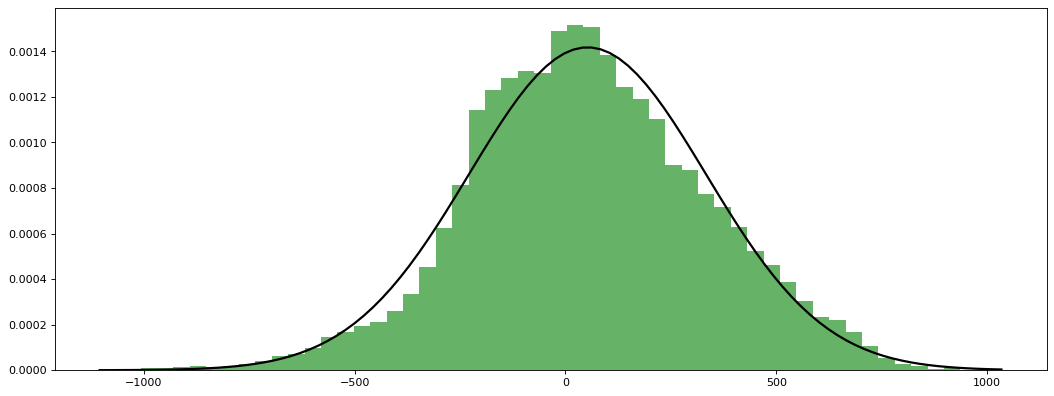

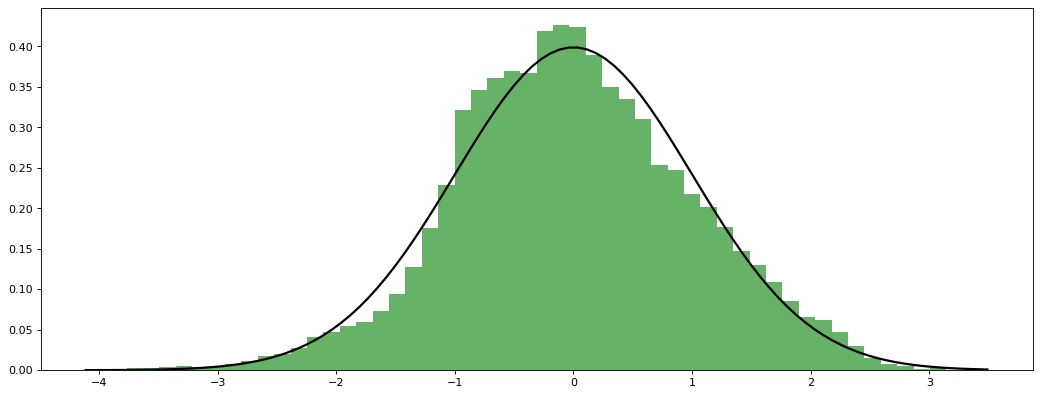

In [ ]:
path = '/SE02/D01_SE02_R01.txt'
df = pd.read_csv("/content/SisFall_dataset"+path,header = None)
df.iloc[:,-1] = df.iloc[:,-1].apply(lambda x: float(str(x).replace(';',''))) # remove ; from last column                              
data = df.iloc[:,3]


plt.figure(num=None,figsize=(16,6),dpi=80,facecolor='w',edgecolor='k')
plt.hist(data, bins=50, density=True, alpha=0.6, color='g')
mu, std = norm.fit(data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
#plt.title(fa("توزیع داده‌ها: mu = %.2f,  std = %.2f" % (mu, std)))
plt.show()

#lablel = pd.read_csv("/content/labels"+path, header = None)
df = (df- df.mean()) / df.std() # standardization

data = df.iloc[:,3]

plt.figure(num=None,figsize=(16,6),dpi=80,facecolor='w',edgecolor='k')
plt.hist(data, bins=50, density=True, alpha=0.6, color='g')
mu, std = norm.fit(data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
#plt.title("Fit results: mu = %.2f,  std = %.2f" % (mu, std))
plt.show()
#plt.show()
#plt.hist(df.iloc[:,0],50);

In [ ]:
path = '/SA01/D11_SA01_R01.txt'
df = pd.read_csv("/content/SisFall_dataset"+path,header = None)
df.iloc[:,-1] = df.iloc[:,-1].apply(lambda x: float(str(x).replace(';',''))) # remove ; from last column                              
lablel = pd.read_csv("/content/labels"+path, header = None)
df = (df- df.mean()) / df.std() # standardization
kalman = df.copy()
kalman.iloc[:,:3] = Kalman(df.iloc[:,:3]) # kalman in acc1
kalman.iloc[:,3:6] = Kalman(df.iloc[:,3:6],[3,4,5]) # kalman in gyc
kalman.iloc[:,6:] = Kalman(df.iloc[:,6:],[6,7,8]) # kalman in acc2
kalman = (kalman- kalman.mean()) / kalman.std() # standardization
index = [_ for _ in range( 0, ceil(df.shape[0]/100) *100,100)]
label_x = [str(_//100) +' S' for _ in index]

## **Show for 3 axes**

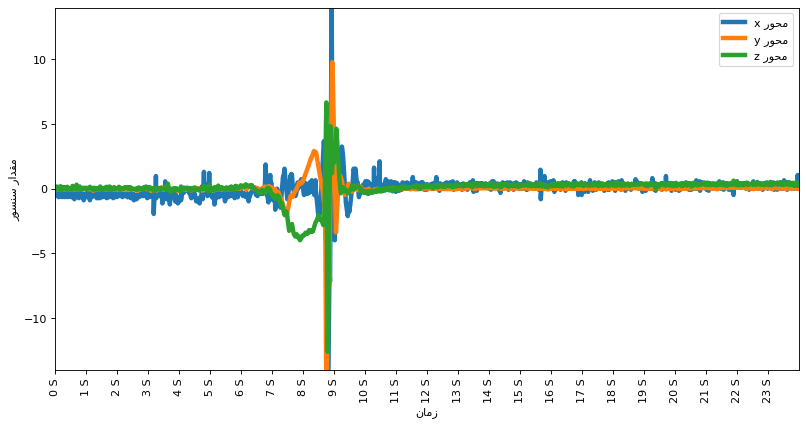

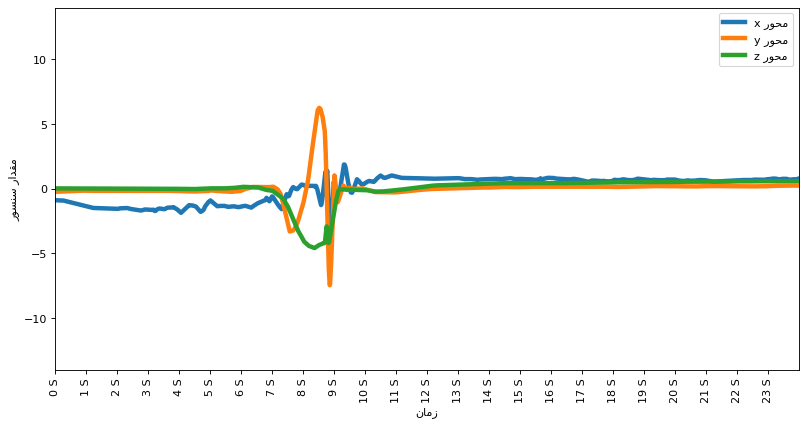

In [ ]:
# for acc1
linewidth = 4
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
Max = max(max(df.iloc[:,0]),max(df.iloc[:,1]),max(df.iloc[:,2]))
plt.plot(df.iloc[:,0],linewidth=linewidth)
plt.plot(df.iloc[:,1],linewidth=linewidth)
plt.plot(df.iloc[:,2],linewidth=linewidth)
plt.xticks(index,label_x, rotation ='vertical')
#plt.title(fa("مقدار سنسور شتاب‌سنج برای سه محور در حالت سقوط"))
plt.xlabel(fa("زمان"))
plt.ylabel(fa("مقدار سنسور"))
plt.legend([fa('محور x'),fa('محور y'),fa('محور z')])    
plt.axis([-1, df.shape[0], -Max,Max])
plt.show()
# for kalman
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(kalman.iloc[:,0],linewidth=linewidth)
plt.plot(kalman.iloc[:,1],linewidth=linewidth)
plt.plot(kalman.iloc[:,2],linewidth=linewidth)
plt.xticks(index,label_x, rotation ='vertical')
#plt.title(fa("مقدار سنسور شتاب‌سنج برای سه محور در حالت سقوط فیلتر شده با کالمن"))
plt.xlabel(fa("زمان"))
plt.ylabel(fa("مقدار سنسور"))
plt.legend([fa('محور x'),fa('محور y'),fa('محور z')])    
plt.axis([-1, df.shape[0], -Max,Max])
plt.show()

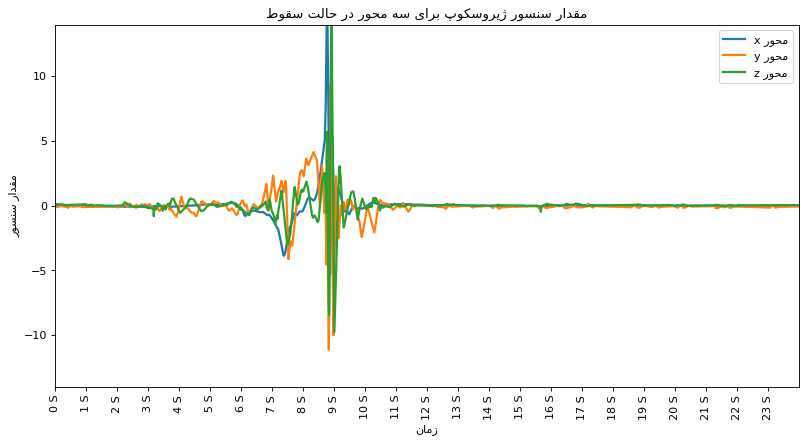

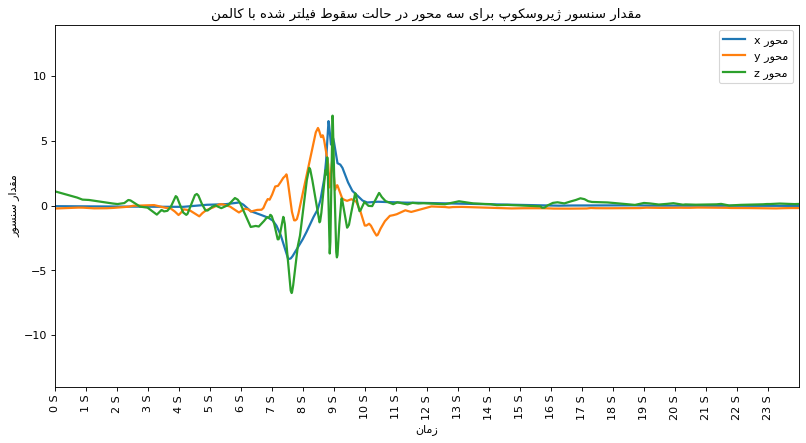

In [ ]:
# for gyc
linewidth = 2
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
Max = max(max(df.iloc[:,0]),max(df.iloc[:,1]),max(df.iloc[:,2]))
plt.plot(df.iloc[:,3],linewidth=linewidth)
plt.plot(df.iloc[:,4],linewidth=linewidth)
plt.plot(df.iloc[:,5],linewidth=linewidth)
plt.xticks(index,label_x, rotation ='vertical')
plt.title(fa("مقدار سنسور ژیروسکوپ برای سه محور در حالت سقوط"))
plt.xlabel(fa("زمان"))
plt.ylabel(fa("مقدار سنسور"))
plt.legend([fa('محور x'),fa('محور y'),fa('محور z')])    
plt.axis([-1, df.shape[0], -Max,Max])
plt.show()
# for kalman
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(kalman.iloc[:,3],linewidth=linewidth)
plt.plot(kalman.iloc[:,4],linewidth=linewidth)
plt.plot(kalman.iloc[:,5],linewidth=linewidth)
plt.xticks(index,label_x, rotation ='vertical')
plt.title(fa("مقدار سنسور ژیروسکوپ برای سه محور در حالت سقوط فیلتر شده با کالمن"))
plt.xlabel(fa("زمان"))
plt.ylabel(fa("مقدار سنسور"))
plt.legend([fa('محور x'),fa('محور y'),fa('محور z')])    
plt.axis([-1, df.shape[0], -Max,Max])
plt.show()

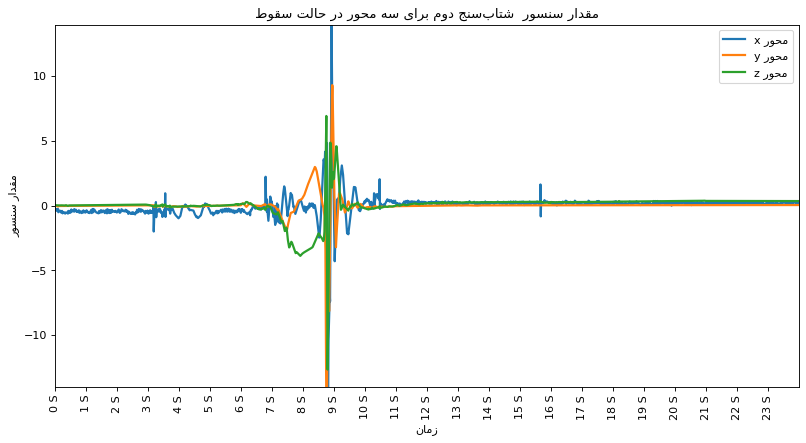

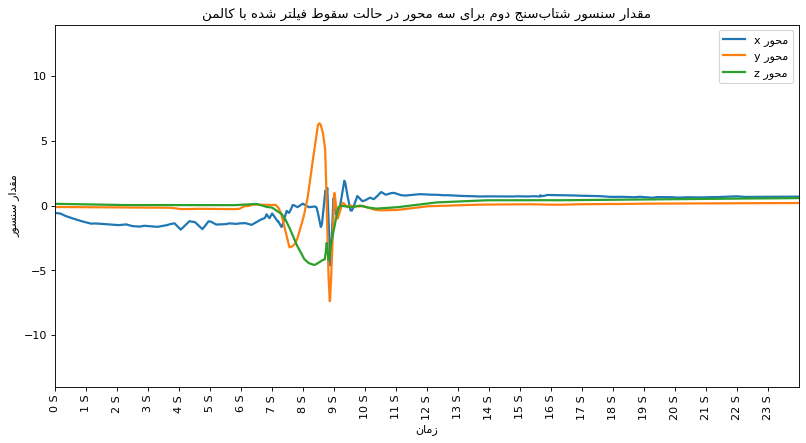

In [ ]:
# for acc2
linewidth = 2
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
Max = max(max(df.iloc[:,0]),max(df.iloc[:,1]),max(df.iloc[:,2]))
plt.plot(df.iloc[:,6],linewidth=linewidth)
plt.plot(df.iloc[:,7],linewidth=linewidth)
plt.plot(df.iloc[:,8],linewidth=linewidth)
plt.xticks(index,label_x, rotation ='vertical')
plt.title(fa("مقدار سنسور  شتاب‌سنج دوم برای سه محور در حالت سقوط"))
plt.xlabel(fa("زمان"))
plt.ylabel(fa("مقدار سنسور"))
plt.legend([fa('محور x'),fa('محور y'),fa('محور z')])    
plt.axis([-1, df.shape[0], -Max,Max])
plt.show()
# for kalman
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(kalman.iloc[:,6],linewidth=linewidth)
plt.plot(kalman.iloc[:,7],linewidth=linewidth)
plt.plot(kalman.iloc[:,8],linewidth=linewidth)
plt.xticks(index,label_x, rotation ='vertical')
plt.title(fa("مقدار سنسور شتاب‌سنج دوم برای سه محور در حالت سقوط فیلتر شده با کالمن"))
plt.xlabel(fa("زمان"))
plt.ylabel(fa("مقدار سنسور"))
plt.legend([fa('محور x'),fa('محور y'),fa('محور z')])    
plt.axis([-1, df.shape[0], -Max,Max])
plt.show()

## **Show for SMA**

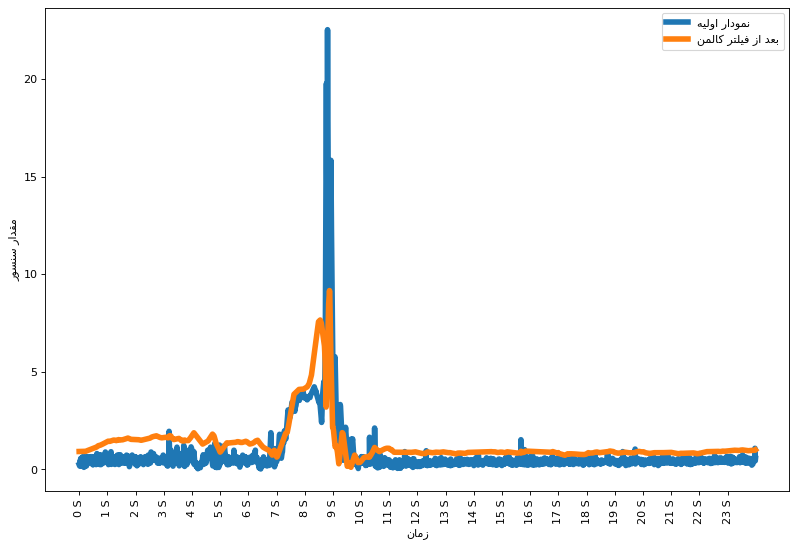

In [ ]:
linewidth = 5
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
sma = (df.iloc[:,0]**2 + df.iloc[:,1]**2 + df.iloc[:,2]**2)**0.5
plt.plot(sma ,linewidth=linewidth)
smakalman = (kalman.iloc[:,0]**2 + kalman.iloc[:,1]**2 + kalman.iloc[:,2]**2)**0.5
plt.plot(smakalman ,linewidth=linewidth)
plt.xticks(index,label_x, rotation ='vertical')
#plt.title(fa("مقدار سنسور شتاب‌سنج اول به صورت مجذور جمع مربع مقادیر محورها"))
plt.xlabel(fa("زمان"))
plt.ylabel(fa("مقدار سنسور"))
plt.legend([fa('نمودار اولیه'),fa('بعد از فیلتر کالمن')],)
plt.show()

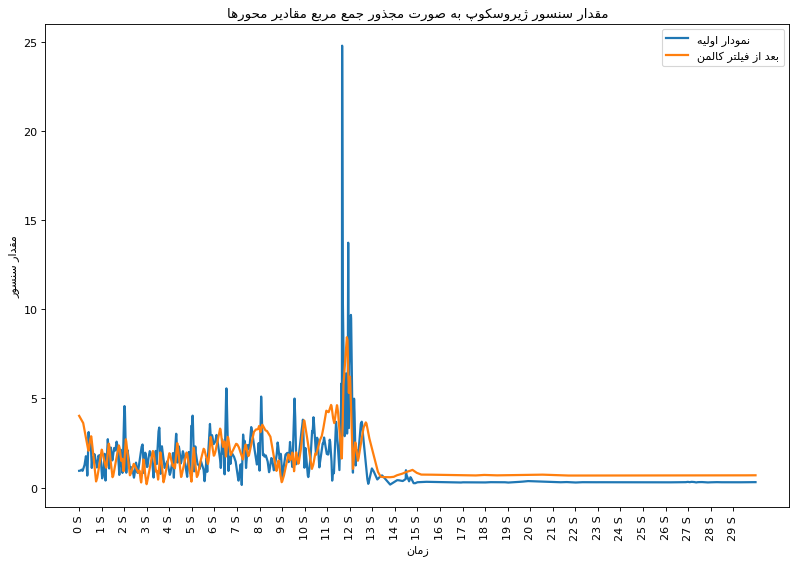

In [ ]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
sma = (df.iloc[:,3]**2 + df.iloc[:,4]**2 + df.iloc[:,5]**2)**0.5
plt.plot(sma ,linewidth=linewidth)
smakalman = (kalman.iloc[:,3]**2 + kalman.iloc[:,4]**2 + kalman.iloc[:,5]**2)**0.5
plt.plot(smakalman ,linewidth=linewidth)
plt.xticks(index,label_x, rotation ='vertical')
plt.title(fa("مقدار سنسور ژیروسکوپ به صورت مجذور جمع مربع مقادیر محورها"))
plt.xlabel(fa("زمان"))
plt.ylabel(fa("مقدار سنسور"))
plt.legend([fa('نمودار اولیه'),fa('بعد از فیلتر کالمن')])
plt.show()

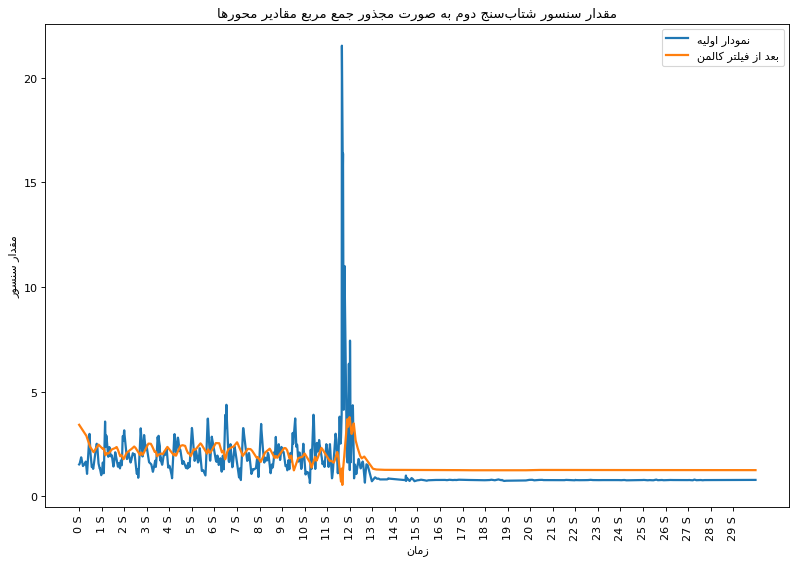

In [ ]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
sma = (df.iloc[:,6]**2 + df.iloc[:,7]**2 + df.iloc[:,8]**2)**0.5
plt.plot(sma ,linewidth=linewidth)
smakalman = (kalman.iloc[:,6]**2 + kalman.iloc[:,7]**2 + kalman.iloc[:,8]**2)**0.5
plt.plot(smakalman ,linewidth=linewidth)
plt.xticks(index,label_x, rotation ='vertical')
plt.title(fa("مقدار سنسور شتاب‌سنج دوم به صورت مجذور جمع مربع مقادیر محورها"))
plt.xlabel(fa("زمان"))
plt.ylabel(fa("مقدار سنسور"))
plt.legend([fa('نمودار اولیه'),fa('بعد از فیلتر کالمن')])
plt.show()

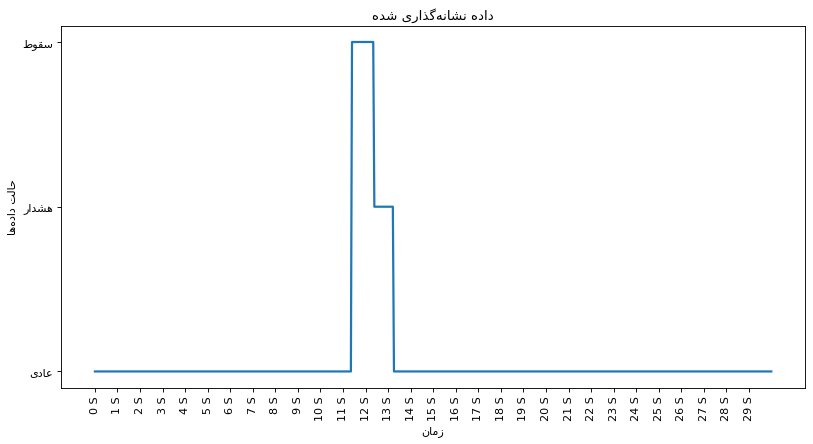

In [ ]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(lablel,linewidth=linewidth)
plt.title(fa("داده نشانه‌گذاری شده"))
plt.xlabel(fa("زمان"))
plt.ylabel(fa("حالت داده‌ها"))
plt.xticks(index,label_x, rotation ='vertical')
plt.yticks([0,1,2],[fa("عادی"),fa("هشدار"),fa("سقوط")])
plt.show()

In [ ]:
%%bash
rm -rf ~/.cache/matplotlib